In [46]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

from time import time
from functools import partial

import sys
sys.path.append('../../')

from Environment import SpringMass
from Subroutines import ModelEstV2,ApproxDAP,max_norm,find_stable_radius,SafeTransit,spectral_radius
from time import time
from Controllers import SafeDAP
from scipy.linalg import sqrtm
import pickle as pkl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class TimeStepsReached(Exception):
    pass
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

# Set up the system

## Find a highly stable spring-mass system

In [79]:
H_benchmark = 20
eps = 0.1

rho_target = eps**(1/H_benchmark)


In [80]:
rho_target

0.8912509381337456

Spectral radius of A: 0.9750991060517634 0.06825843420793448 0.49864317719130735
Step 0
Step 100
rho(A_pow[-1]) 0.6039140947794956 Sum(A_pow) 27.96453063776236 dx/w_max 9.198855949267108


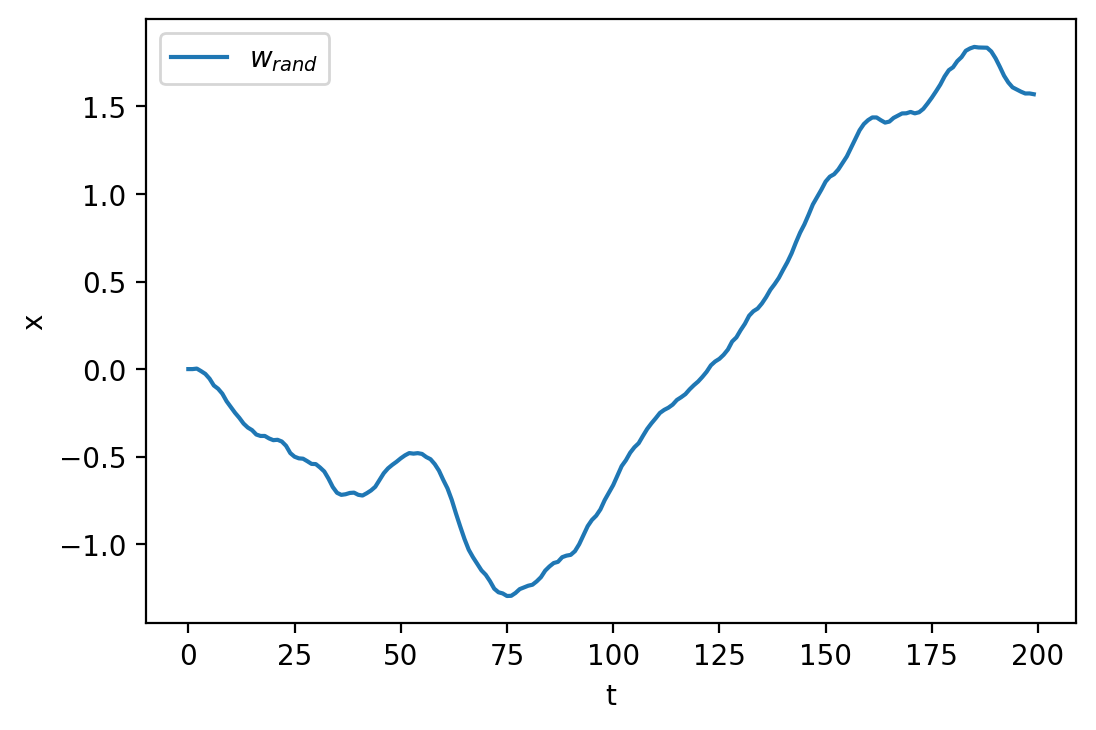

In [81]:
w_max = 0.2


dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.05
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max=w_max)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()


A = env.A
B = env.B

A_pow = [np.eye(2)]
for i in range(H_benchmark):
    A_pow.append(A_pow[-1].dot(A))
            
print('rho(A_pow[-1])',spectral_radius(A_pow[-1]),'Sum(A_pow)',np.sum([np.linalg.norm(A,1) for A in A_pow]),'dx/w_max',np.max(x_rand_disturbance)/w_max)


# Experiments

## Experiment parameters

In [43]:
### Find a region(B(A,eps_init)) around A and ensure it contains only stable matrices.
eps_init = find_stable_radius(A)

est = ModelEstV2(A,B,eps_init) # The model estimator.
# est = ModelEstV3() # The model estimator.

H = 5# Look back length



# Constants
x_dim = A.shape[-1]
u_dim = B.shape[-1]

I_x = np.eye(x_dim)  
I_u = np.eye(u_dim)  


w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.

# Optimaization Problem Parameters

Q = np.array([[1,0],
                [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints4
d_x = np.array([10.0,40.0,10.0,40.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([50.0,50.0])


M0 = np.zeros((H,u_dim,x_dim))

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0

refit_per_step = 50
pre_run_steps = 2
TD_steps  = 30 # The least number of steps taken in Phase 1.

# eta_bars = [0.1,0.5,1.0,1.5,2.0]
eta_bars = [0.1]

# eta_bars = [0.1]

params = {'Q':Q,'R':R,'D_x':D_x,'d_x':d_x,'D_u':D_u,'d_u':d_u,'A':A,'B':B,'H':H,'H_benchmark':H_benchmark,'eta_bars':eta_bars,'w_max':w_max}
with open('./data/Parameters.pkl','wb') as f:
    pkl.dump(params,f)

In [44]:

def PlainSim(timesteps,n_trials):
    
    def main_loop():
        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max = w_max)

        x_no_control_hist = []
        # main loop
        for _ in range(timesteps):
            x = env.state()
            u = 0 
            env.step(u)

            x_no_control_hist.append(x)

            if _%100 == 0:
                print('Step',_)

        data = {}
        data['x'] = x_no_control_hist
        return data
    
    trial_data = []
    _ = 0 
    while _ < n_trials: 
        t = time()
        print('Trial {}'.format(_))
        trial_data.append(main_loop())
        _+=1

        print('Time for trial:',time()-t)
    return trial_data

def BenchmarkSim(timesteps,n_trials,unconstrained=False):

    def main_loop(M):
        # Reset the environment
        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max = w_max)

        x_true_hist = []
        u_true_hist = []
        w_true_hist = [np.zeros((x_dim,1)) for _ in range(10*H_benchmark)]

        # main loop 
        for _ in range(timesteps):
            x = env.state()
            x_true_hist.append(x)
            if _<pre_run_steps:
                u = (np.random.rand()-0.5)*2*0
            else:
                u = ApproxDAP(M,w_true_hist,0)

            env.step(u)
            u_true_hist.append(u)

            w_true_hist.append(env.state()-A.dot(x_true_hist[-1])-B.dot(u_true_hist[-1]))

            if _%100 == 0:
                print('Step',_)

        # Prepare data output
        data = {}
        data['x'] = x_true_hist
        data['u'] = u_true_hist
        data['w'] = w_true_hist
        
#         print(data['w'])
        return data



    safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

    if unconstrained:
        M,Phi = safeDapSolver.solve(A,B,H_benchmark,e_x=e_x,e_u=e_u,unconstrained=True)
    else:
        M,Phi = safeDapSolver.solve(A,B,H_benchmark,e_x=e_x,e_u=e_u)
    
    print('M',M)

    trial_data = []
    _ = 0 
    while _ < n_trials: 

        print('Trial {}'.format(_))
        trial_data.append(main_loop(M))
        _+=1
        
    return trial_data    

In [45]:

n_trials = 10
timesteps = 400

alg_dict = {
    'Plain':PlainSim,
#             'UnconstrainedDAP':partial(BenchmarkSim,unconstrained=True),
            'ConstrainedDAP':partial(BenchmarkSim,unconstrained=False)
           }


for key, alg in alg_dict.items():
    print("{} starts.".format(key))
    
    t = time()
      

    trial_data = alg(timesteps,n_trials)
    with open('./data/{}.pkl'.format(key),'wb') as f:
        pkl.dump(trial_data,f)
    
    print('Total Time for {}:'.format(key),time()-t)


Plain starts.
Trial 0
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.008612871170043945
Trial 1
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.006253242492675781
Trial 2
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.003082752227783203
Trial 3
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.002798795700073242
Trial 4
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.002682924270629883
Trial 5
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.002855062484741211
Trial 6
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.00299072265625
Trial 7
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.0030374526977539062
Trial 8
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.0031168460845947266
Trial 9
Step 0
Step 100
Step 200
Step 300
Time for trial: 0.0038585662841796875
Total Time for Plain: 0.05534553527832031
ConstrainedDAP starts.
A_pow [array([[1., 0.],
       [0., 1.]]), array([[ 1.        ,  0.1       ],
       [-0.0028985 ,  0.98008237]]), array([[ 0.999710

In [15]:
for eta_bar in eta_bars:

    def SafeAdaptiveSim(timesteps,unconstrained=False):
        # Data containers

        x_hist = []
        u_hist = []
        w_hat_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]

        theta_hist = []
        refit_time_step = []
        phase1_endpoints =[]
        phase2_endpoints=[]
        M_hist = [M0]
        r_hist = []

        n_episode = 0

        def phase(A_hat,B_hat,old_eta,new_eta):
            # Local variables: A_hat,B_hat,old,new.
            # Global variables: theta_hist,M_hist,e_x,e_u,H,env,w_max, w_hat_hist
            # Start of the phase
            # Solve for new controller M.
            if unconstrained:
                M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u,unconstrained=True)
            else:
                M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u)

            if n_episode==1:
                 old = {'M':np.array(M),'theta':(np.array(A_hat),np.array(B_hat)),'eta':old_eta,'r':r_hist[-1]}
            else:
                old = {'M':np.array(M_hist[-1]),'theta':theta_hist[-2],'eta':old_eta,'r':r_hist[-2]}
            new = {'M':np.array(M),'theta':theta_hist[-1],'eta':new_eta,'r':r_hist[-1]}

            old['e_x']=new['e_x']=e_x
            old['e_u']=new['e_u']=e_u

            M_hist.append(np.array(M))

            # Compute mid.
            mid = safeDapSolver.mid(old,new,H)

            transit = SafeTransit(old,new,mid,H)

            for i in range(refit_per_step):
                x = env.state()
                u = transit.get_u(w_hat_hist)
                env.step(u)

                Ah,Bh = transit.get_theta()
                # Calculate the estimated disturbance, and project it onto the bounded disturbance set. 
                w_hat = env.state()-Ah.dot(x)-Bh.dot(u)
                w_hat[w_hat>w_max] = w_max
                w_hat[w_hat<-w_max] = -w_max 
                w_hat_hist.append(np.array(w_hat)) 

                u_hist.append(u)
                x_hist.append(x)

                if len(x_hist)>=timesteps:
                    raise TimeStepsReached # Use the exception mechanism to stop the main loop once the total timestep is reached.

                # Updating M in the transit object.
                transit.step()
            # End of the phase


        env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0,w_max=w_max)

        safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

        try:
        # main loop
            while True:

                if n_episode==0:
                    for i in range(pre_run_steps):
                        x = env.state()
                        x_hist.append(x)
                        u = (np.random.rand()-0.5)*2*eta_bar
                        env.step(u)
                        u_hist.append(u)
                    A_hat,B_hat,r = est.est(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim))
#                     print(A_hat,B_hat)
                    theta_hist.append((np.array(A_hat),np.array(B_hat)))
                    r_hist.append(float(r))
                    refit_time_step.append(len(x_hist))
    #                 print(A_hat,B_hat)

                    # Fit the system parameters for the first time.
                else:

                    # Phase 1: exploration exploitation 

#                     print('phase 1')
                    phase(A_hat,B_hat,0,eta_bar)

                    phase1_endpoints.append(len(x_hist))

                    # Refit the system model
                    A_hat,B_hat,r = est.est(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim))
#                     print(A_hat,B_hat)
                    theta_hist.append((np.array(A_hat),np.array(B_hat)))
                    r_hist.append(float(r))
                    refit_time_step.append(len(x_hist))

                    # Phase 2: pure exploitation 
#                     print('phase 2')
                    phase(A_hat,B_hat,eta_bar,0)

                    phase2_endpoints.append(len(x_hist))


                    print('Episode',n_episode)

                n_episode+=1

        except TimeStepsReached:
            print('Time Steps Reached')
            # Prepare data output


        # Prepare data output
        data = {}
        data['x'] = x_hist
        data['u'] = u_hist
        data['w'] = w_hat_hist
        return data
    
    alg_dict = {'SafeLearning':partial(SafeAdaptiveSim,unconstrained=False),
               'UnconstrainedLearning':partial(SafeAdaptiveSim,unconstrained=True)
               }


    n_trials = 5
    time_steps = 400
    for key, alg in alg_dict.items():
        print("{} starts.".format(key))
        trial_data = []
        _ = 0 
        while _ < n_trials: 
            t = time()
            try:
                print('Trial {}'.format(_))
                trial_data.append(alg(time_steps))
                _+=1
            except AttributeError:
                print('Infeasibility Encountered. Restarting the loop.')
            except cp.SolverError:
                print('Solver Error Encountered. Restarting the loop.')
            
            print('Time for trial:',time()-t)
            
        with open('./data/{}_eta_{}.pkl'.format(key,eta_bar),'wb') as f:
            pkl.dump(trial_data,f)

SafeLearning starts.
Trial 0
A_pow [array([[1., 0.],
       [0., 1.]]), array([[ 9.99291155e-01,  9.99291155e-02],
       [-3.34918464e-04,  9.89349334e-01]]), array([[ 9.98549344e-01,  1.98723085e-01],
       [-6.66032418e-04,  9.78778636e-01]]), array([[ 9.97774971e-01,  2.96390705e-01],
       [-9.93371341e-04,  9.68287436e-01]]), array([[ 0.99696844,  0.39294072],
       [-0.00131696,  0.95787526]]), array([[ 0.99613014,  0.48838181],
       [-0.00163684,  0.94754165]]), array([[ 0.99526047,  0.58272262],
       [-0.00195303,  0.93728613]]), array([[ 0.99435982,  0.67597174],
       [-0.00226556,  0.92710825]]), array([[ 0.99342857,  0.76813768],
       [-0.00257446,  0.91700753]]), array([[ 0.99246712,  0.85922894],
       [-0.00287976,  0.90698353]]), array([[ 0.99147585,  0.94925395],
       [-0.00318148,  0.89703578]])]
Sum of (A_pow norm1)*w_max 0.047216801686439124
A_pow [array([[1., 0.],
       [0., 1.]]), array([[ 9.99291155e-01,  9.99291155e-02],
       [-3.34918464e-04,  

/home/tianpeng/miniconda3/envs/simulation/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


A_pow [array([[1., 0.],
       [0., 1.]]), array([[ 1.        ,  0.1       ],
       [-0.00130963,  0.99027561]]), array([[ 0.99986904,  0.19902756],
       [-0.00260653,  0.98051483]]), array([[ 0.99960838,  0.29707904],
       [-0.00389065,  0.97071927]]), array([[ 0.99921932,  0.39415097],
       [-0.00516193,  0.96089056]]), array([[ 0.99870313,  0.49024003],
       [-0.00642035,  0.95103029]]), array([[ 0.99806109,  0.58534306],
       [-0.00766585,  0.94114007]]), array([[ 0.99729451,  0.67945706],
       [-0.00889839,  0.93122148]]), array([[ 0.99640467,  0.77257921],
       [-0.01011795,  0.92127608]]), array([[ 0.99539287,  0.86470682],
       [-0.01132449,  0.91130544]]), array([[ 0.99426042,  0.95583736],
       [-0.01251796,  0.9013111 ]])]
Sum of (A_pow norm1)*w_max 0.047394317507493955
A_pow [array([[1., 0.],
       [0., 1.]]), array([[ 1.        ,  0.1       ],
       [-0.00130963,  0.99027561]]), array([[ 0.99986904,  0.19902756],
       [-0.00260653,  0.98051483]]), ar